In [2]:
import pandas as pd
import numpy as np
import glob
import pickle

import os
from scipy.interpolate import interp1d
import re

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

# Load Data


In [3]:
#ForKK Local
FileSource = "./GeneratedDataDouble/allData.pickle"
NYC_FileSource = "./GeneratedDataDouble/NYC_allData.pickle"
ISR_FileSource = "./GeneratedDataDouble/ISR_allData.pickle"
ImagePath = "./Visualizations/"

In [4]:
OutputColumns = ["ApproachRate", "ApproachRateOther", 
                 "Rel_Pos_Magnitude", 
                 "ScenarioTime", 
                 "Filtered_Accel1","Filtered_Accel2",
                 "Filtered_Steer1","Filtered_Steer2",
                 "1_Head_Center_Distance","2_Head_Center_Distance",
                 'Adjusted_1_Head_Center_Distance', 'Adjusted_2_Head_Center_Distance',
                 "Filtered_1_Head_Velocity_Total","Filtered_2_Head_Velocity_Total",
                 "1_Turn", "2_Turn",
                 "Centerline_Offset_1", "Centerline_Offset_2",
                 '1_Indicator', '2_Indicator',
                 "RelativeRotation"]

In [5]:
FileList = []
with open(FileSource, 'rb') as f:
    FileList = pickle.load(f)

In [6]:
def separate_letters_numbers(s):
    match = re.match(r"([a-zA-Z]+)([0-9]+)", s)
    if match:
        letters, numbers = match.groups()
        return letters.upper(), numbers
    else:
        return s, ""

In [7]:
def extract_scenario_location_run(file_name):
    base_name = os.path.basename(file_name)
    parts = base_name.split('_')
    scenario = parts[0]
    location = separate_letters_numbers(parts[1])[0]
    run = separate_letters_numbers(parts[1])[1] + '_' + parts[2].split('.')[0]  # Remove the file extension
    return scenario, location, run

In [8]:
def adjust_signs_based_on_min_distance(df, distance_col, adjusted_distance_col):
    # Initialize the adjusted distance column
    df[adjusted_distance_col] = df[distance_col]

    # Determine the point of minimum distance
    min_distance_index = df[distance_col].idxmin()
    
    # Adjust distances before the minimum distance (towards the center)
    df.loc[:min_distance_index, adjusted_distance_col] *= -1

    # Ensure only one direction change is applied
    direction_changed = False

    for i in range(1, len(df)):
        # Check the current direction based on the velocity and distance
        if i <= min_distance_index:
            # Should be negative, moving towards the center
            if df.loc[i, adjusted_distance_col] > 0:
                df.loc[i, adjusted_distance_col] *= -1
        else:
            # Should be positive, moving away from the center
            if df.loc[i, adjusted_distance_col] < 0:
                df.loc[i, adjusted_distance_col] *= -1

        # Allow only one change in direction after reaching the minimum distance
        if i > min_distance_index and not direction_changed:
            direction_changed = True

    return df


In [9]:
# Initialize dictionaries to hold data by scenario and location
data_by_scenario = {}
data_by_scenario_location = {}
data_by_run = {} 

for file_path in FileList:
    if not os.path.exists(file_path):
        print(f"Could not find {file_path}")
        continue
    
    # print(file_path)
    data = pd.read_feather(file_path)
    
    # Adjust distance with sign
    # data['1_Distance_Change'] = data['1_Head_Center_Distance'].diff()
    # data['Adjusted_1_Head_Center_Distance'] = data['1_Head_Center_Distance']
    # data.loc[data['1_Distance_Change'] < 0, 'Adjusted_1_Head_Center_Distance'] *= -1
    
    # data['2_Distance_Change'] = data['2_Head_Center_Distance'].diff()
    # data['Adjusted_2_Head_Center_Distance'] = data['2_Head_Center_Distance']
    # data.loc[data['2_Distance_Change'] < 0, 'Adjusted_2_Head_Center_Distance'] *= -1
    
    # Apply the adjustment to each run
    data = adjust_signs_based_on_min_distance(data, '1_Head_Center_Distance', 'Adjusted_1_Head_Center_Distance')
    data = adjust_signs_based_on_min_distance(data, '2_Head_Center_Distance', 'Adjusted_2_Head_Center_Distance')

    df = data[OutputColumns]
    
    # Extract scenario, location, and run from the file name
    scenario, location, run = extract_scenario_location_run(file_path)
    
    # Store features in dictionaries by run
    data_by_run[scenario + '_' + location + '_' + run] = df
    
    # Store features in dictionaries by scenario
    if scenario not in data_by_scenario:
        data_by_scenario[scenario] = []
    data_by_scenario[scenario].append(df)
    
    # Append data to the corresponding scenario and location
    if scenario not in data_by_scenario_location:
        data_by_scenario_location[scenario] = {}
    if location not in data_by_scenario_location[scenario]:
        data_by_scenario_location[scenario][location] = []
    data_by_scenario_location[scenario][location].append(df)

In [10]:
len(data_by_run), len(data_by_scenario), len(data_by_scenario['CP5']), len(data_by_scenario_location['CP5']), len(data_by_scenario_location['CP5']['NYC'])

(928, 7, 122, 3, 58)

# Did the car stop?
- Time-wise stopping point -> head-center distance: plot (y-velocity, x-time) add vertical line for the car stop, exporting small pngs and upload to github 

Run: CP5_ISR_33_1B, Stopped Duration: {1: 39, 'all': 39}


/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_66354/2063255765.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


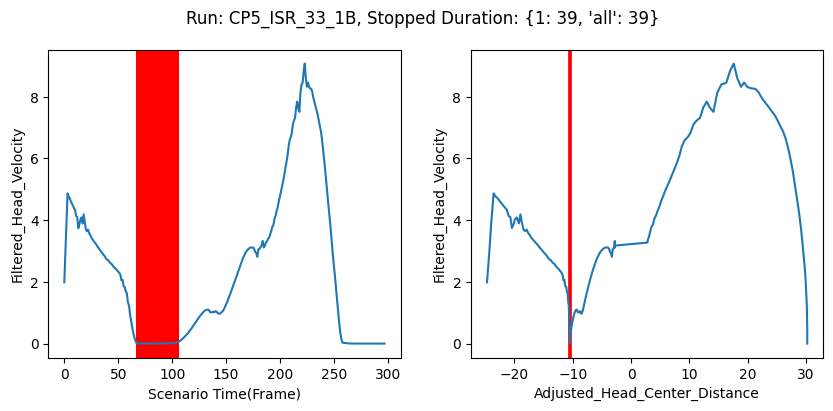

In [10]:
# Define velocity threshold
velocity_threshold = 0.05

# Initialize lists to hold runs below and above the threshold
stopped_runs = {}
# not_stopped_runs = {}
min_velocity = []
stopped_durations = {}
all_stopped_durations = []

# Categorize the runs based on the threshold and calculate stopped durations
# for run, df in data_by_run.items():
# run = 'CP5_NYC_24_1A' # stopped
run = 'CP5_ISR_33_1B'
# run = 'CP7_ISR_14_1A' # didn't stop
df = data_by_run[run]

# specifying the plot size
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

min_velocity.append(df['Filtered_1_Head_Velocity_Total'].min())

# if df['Filtered_1_Head_Velocity_Total'].min() < velocity_threshold:
stopped_runs[run] = df
stopped_durations[run] = {}

# Calculate how long the car was stopped
velocity_below_threshold = df['Filtered_1_Head_Velocity_Total'] < velocity_threshold
total_stopped_time = 0
current_stopped_time = 0
stopped_period = 0

for i in range(len(velocity_below_threshold)):
    d = df.loc[i, 'Adjusted_1_Head_Center_Distance']
    if abs(d) < 20:
        if velocity_below_threshold.iloc[i]:
            ax1.axvline(x = i, color = 'r', label = 'axvline - full height')
            d = df.loc[i, 'Adjusted_1_Head_Center_Distance']
            ax2.axvline(x = d, color = 'r', linestyle = '-') 
            current_stopped_time += 1  # Increment the count for continuous stop
        else:
            if current_stopped_time > 0:
                stopped_period += 1
                stopped_durations[run][stopped_period] = current_stopped_time
                all_stopped_durations.append(current_stopped_time)
                total_stopped_time += current_stopped_time
                current_stopped_time = 0

# Add the final continuous stopped time if the last period was a stop
# if current_stopped_time > 0:
#     stopped_durations[run]['end'] = current_stopped_time
#     total_stopped_time += current_stopped_time

# Store the total stopped duration
stopped_durations[run]['all'] = total_stopped_time
# stopped_durations[run]['all-end'] = total_stopped_time - current_stopped_time
    
# else:
#     not_stopped_runs[run] = df

# Output the stopped durations
# for run, duration in stopped_durations.items():
duration = stopped_durations[run]
print(f"Run: {run}, Stopped Duration: {duration}")

ax1.plot(df['Filtered_1_Head_Velocity_Total'])
ax1.set(xlabel="Scenario Time(Frame)", ylabel="Filtered_Head_Velocity")

# plt.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total']) 
ax2.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total'])
ax2.set(xlabel="Adjusted_Head_Center_Distance", ylabel="Filtered_Head_Velocity")

fig.suptitle(f"Run: {run}, Stopped Duration: {duration}")
# fig.savefig(f"{ImagePath}{run}_waited{duration['all-end']}")

fig.show()


In [12]:
# Define velocity threshold
velocity_threshold = 0.05

# Initialize lists to hold runs below and above the threshold
stopped_runs = {}
# not_stopped_runs = {}
min_velocity = []
stopped_durations = {}
all_stopped_durations = []

# Categorize the runs based on the threshold and calculate stopped durations
for run, df in data_by_run.items():
# run = 'CP7_ISR_14_1A'
# df = data_by_run[run]

    # specifying the plot size
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

    min_velocity.append(df['Filtered_1_Head_Velocity_Total'].min())

    # if df['Filtered_1_Head_Velocity_Total'].min() < velocity_threshold:
    stopped_runs[run] = df
    stopped_durations[run] = {}

    # Calculate how long the car was stopped
    velocity_below_threshold = df['Filtered_1_Head_Velocity_Total'] < velocity_threshold
    total_stopped_time = 0
    current_stopped_time = 0
    stopped_period = 0

    for i in range(len(velocity_below_threshold)):
        d = df.loc[i, 'Adjusted_1_Head_Center_Distance']
        if abs(d) < 20:
            if velocity_below_threshold.iloc[i]:
                ax1.axvline(x = i, color = 'r', label = 'axvline - full height')
                d = df.loc[i, 'Adjusted_1_Head_Center_Distance']
                ax2.axvline(x = d, color = 'r', linestyle = '-') 
                current_stopped_time += 1  # Increment the count for continuous stop
            else:
                if current_stopped_time > 0:
                    stopped_period += 1
                    stopped_durations[run][stopped_period] = current_stopped_time
                    all_stopped_durations.append(current_stopped_time)
                    total_stopped_time += current_stopped_time
                    current_stopped_time = 0

    # Add the final continuous stopped time if the last period was a stop
    # if current_stopped_time > 0:
    #     stopped_durations[run]['end'] = current_stopped_time
    #     total_stopped_time += current_stopped_time

    # Store the total stopped duration
    stopped_durations[run]['all'] = total_stopped_time
    # stopped_durations[run]['all-end'] = total_stopped_time - current_stopped_time
        
    # else:
    #     not_stopped_runs[run] = df

    # Output the stopped durations
    # for run, duration in stopped_durations.items():
    duration = stopped_durations[run]
    print(f"Run: {run}, Stopped Duration: {duration}")

    ax1.plot(df['Filtered_1_Head_Velocity_Total'])
    ax1.set(xlabel="Scenario Time(Frame)", ylabel="Filtered_Head_Velocity")

    # plt.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total']) 
    ax2.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total'])
    ax2.set(xlabel="Adjusted_Head_Center_Distance", ylabel="Filtered_Head_Velocity")

    fig.suptitle(f"Run: {run}, Stopped Duration: {duration}")
    # fig.savefig(f"{ImagePath}{run}_waited{duration['all']}")

    # fig.show()
    # break

Run: CP7_NYC_22_1A, Stopped Duration: {'all': 0}
Run: CP7_NYC_22_1B, Stopped Duration: {1: 12, 'all': 12}
Run: CP3_NYC_22_1A, Stopped Duration: {'all': 0}
Run: CP3_NYC_22_1B, Stopped Duration: {'all': 0}
Run: CP2_NYC_22_1A, Stopped Duration: {1: 33, 'all': 33}
Run: CP2_NYC_22_1B, Stopped Duration: {1: 22, 2: 22, 3: 87, 'all': 131}
Run: CP6_NYC_1_1A, Stopped Duration: {1: 14, 'all': 14}
Run: CP6_NYC_1_1B, Stopped Duration: {1: 15, 'all': 15}
Run: CP7_NYC_1_1A, Stopped Duration: {'all': 0}
Run: CP7_NYC_1_1B, Stopped Duration: {'all': 0}
Run: CP7_NYC_25_1A, Stopped Duration: {'all': 0}
Run: CP7_NYC_25_1B, Stopped Duration: {'all': 0}
Run: CP3_NYC_25_1A, Stopped Duration: {'all': 0}
Run: CP3_NYC_25_1B, Stopped Duration: {1: 27, 'all': 27}
Run: CP1_NYC_25_1A, Stopped Duration: {1: 22, 'all': 22}
Run: CP1_NYC_25_1B, Stopped Duration: {'all': 0}
Run: CP6_NYC_25_1A, Stopped Duration: {1: 23, 'all': 23}
Run: CP6_NYC_25_1B, Stopped Duration: {'all': 0}
Run: CP2_NYC_25_1A, Stopped Duration: {'all

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_96374/2290659651.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 4))


Run: CP3_NYC_13_1A, Stopped Duration: {1: 226, 'all': 226}
Run: CP3_NYC_13_1B, Stopped Duration: {1: 32, 'all': 32}
Run: CP5_NYC_13_1A, Stopped Duration: {1: 176, 'all': 176}
Run: CP5_NYC_13_1B, Stopped Duration: {1: 149, 'all': 149}
Run: CP1_NYC_13_1A, Stopped Duration: {1: 23, 2: 117, 3: 85, 'all': 225}
Run: CP1_NYC_13_1B, Stopped Duration: {1: 26, 'all': 26}
Run: CP2_NYC_13_1A, Stopped Duration: {1: 23, 'all': 23}
Run: CP2_NYC_13_1B, Stopped Duration: {1: 46, 'all': 46}
Run: CP8_NYC_13_1A, Stopped Duration: {1: 26, 2: 92, 'all': 118}
Run: CP8_NYC_13_1B, Stopped Duration: {1: 41, 'all': 41}
Run: CP6_NYC_13_1A, Stopped Duration: {1: 28, 'all': 28}
Run: CP6_NYC_13_1B, Stopped Duration: {1: 113, 'all': 113}
Run: CP8_NYC_8_1A, Stopped Duration: {'all': 0}
Run: CP8_NYC_8_1B, Stopped Duration: {1: 20, 'all': 20}
Run: CP3_NYC_8_1A, Stopped Duration: {1: 111, 'all': 111}
Run: CP3_NYC_8_1B, Stopped Duration: {1: 23, 'all': 23}
Run: CP7_NYC_8_1A, Stopped Duration: {1: 85, 'all': 85}
Run: CP7_N

KeyboardInterrupt: 

# Where would the car stop?

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_47974/353317790.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


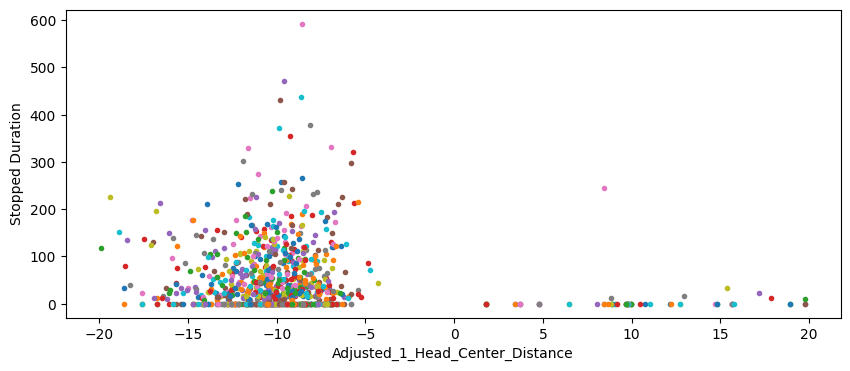

In [21]:
# Define velocity threshold
velocity_threshold = 0.05

# Initialize lists to hold runs below and above the threshold
stopped_runs = {}
# not_stopped_runs = {}
min_velocity = []
stopped_durations = {}
all_stopped_durations = []
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Run', 'Distance', 'Stopped_Duration'])

# Function to add a new row to the DataFrame
def add_to_results(run, distance, duration):
    global results_df
    new_row = pd.DataFrame({'Run': [run], 'Distance': [distance], 'Stopped_Duration': [duration]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# specifying the plot size
fig, ax = plt.subplots(figsize=(10, 4))
    
# Categorize the runs based on the threshold and calculate stopped durations
for run, df in data_by_run.items():
# run = 'CP7_ISR_14_1A'
# df = data_by_run[run]

    min_velocity.append(df['Filtered_1_Head_Velocity_Total'].min())

    # if df['Filtered_1_Head_Velocity_Total'].min() < velocity_threshold:
    stopped_runs[run] = df
    stopped_durations[run] = {}

    # Calculate how long the car was stopped
    velocity_below_threshold = df['Filtered_1_Head_Velocity_Total'] < velocity_threshold
    total_stopped_time = 0
    current_stopped_time = 0
    stopped_period = 0

    for i in range(len(velocity_below_threshold)):
        d = df.loc[i, 'Adjusted_1_Head_Center_Distance']
        if abs(d) < 20:
            if velocity_below_threshold.iloc[i]:
                if total_stopped_time == 0:
                    start_d = d
                current_stopped_time += 1  # Increment the count for continuous stop
            else:
                if current_stopped_time > 0:
                    stopped_period += 1
                    stopped_durations[run][stopped_period] = current_stopped_time
                    all_stopped_durations.append(current_stopped_time)
                    total_stopped_time += current_stopped_time
                    current_stopped_time = 0


    # Add the final continuous stopped time if the last period was a stop
    # if current_stopped_time > 0:
    #     stopped_durations[run]['end'] = current_stopped_time
    #     total_stopped_time += current_stopped_time

    # Store the total stopped duration
    stopped_durations[run]['all'] = total_stopped_time
    # save total stopped time for this run
    ax.scatter(start_d, total_stopped_time,  marker='.')
    add_to_results(run, start_d, total_stopped_time)
    # stopped_durations[run]['all-end'] = total_stopped_time - current_stopped_time
        
    # else:
    #     not_stopped_runs[run] = df

    # Output the stopped durations
    # for run, duration in stopped_durations.items():
    duration = stopped_durations[run]
    # print(f"Run: {run}, Stopped Duration: {duration}")

    ax.set(xlabel="Adjusted_1_Head_Center_Distance", ylabel="Stopped Duration")
    # fig.savefig(f"{ImagePath}{run}_waited{duration['all']}")

fig.show()
    # break

In [22]:
results_df

,Run,Distance,Stopped_Duration
0,CP7_NYC_22_1A,-11.410038,0
1,CP7_NYC_22_1B,-16.775637,12
2,CP3_NYC_22_1A,-16.775637,0
3,CP3_NYC_22_1B,-16.775637,0
4,CP2_NYC_22_1A,-7.043505,33
...,...,...,...
923,CP3_ISR_03_1B,-7.697515,26
924,CP7_ISR_03_1A,-7.697515,0
925,CP7_ISR_03_1B,-9.573007,258
926,CP1_ISR_03_1A,-10.344974,56


In [23]:
results_df['Run'].nunique()

928

In [24]:
results_df['Distance'].astype('float').describe()

count    928.000000
mean      -8.784782
std        6.196808
min      -19.917442
25%      -11.623353
50%       -9.916835
75%       -8.237559
max       19.803612
Name: Distance, dtype: float64

In [27]:
results_df['Stopped_Duration'].astype('float').describe()

count    928.000000
mean      49.203664
std       70.102118
min        0.000000
25%        0.000000
50%       22.000000
75%       74.000000
max      593.000000
Name: Stopped_Duration, dtype: float64

In [26]:
import plotly.express as px

fig = px.box(results_df, y='Distance', title='Boxplot of Distances')
fig.update_layout(yaxis_title='Distance', width=800, height=400)
fig.show()

In [28]:
import plotly.express as px

fig = px.box(results_df, y='Stopped_Duration', title='Boxplot of Stopped Duration')
fig.update_layout(yaxis_title='Stopped_Duration', width=800, height=400)
fig.show()

### Data Processing


In [32]:
features = ["ApproachRateOther", 
            "Rel_Pos_Magnitude", 
            "Filtered_Steer2", 
            "1_Head_Center_Distance", "2_Head_Center_Distance", 
            "Filtered_2_Head_Velocity_Total",
            "1_Turn",
            "2_Indicator",
            "Centerline_Offset_2",
            "RelativeRotation"]

In [30]:
data_by_run['CP1_ISR_01_1A']

,ApproachRate,ApproachRateOther,Rel_Pos_Magnitude,ScenarioTime,Filtered_Accel1,Filtered_Accel2,Filtered_Steer1,Filtered_Steer2,1_Head_Center_Distance,2_Head_Center_Distance,...,Adjusted_2_Head_Center_Distance,Filtered_1_Head_Velocity_Total,Filtered_2_Head_Velocity_Total,1_Turn,2_Turn,Centerline_Offset_1,Centerline_Offset_2,1_Indicator,2_Indicator,RelativeRotation
0,-2.516276,1.486932,54.555162,0.0000,0.18008,0.09984,0.01296,-0.01800,34.958369,19.642789,...,-19.642789,1.035505,1.495974,-1,0,0.266251,0.644688,0,0,162.2695
1,-3.693139,2.173041,54.103482,0.0757,0.24158,0.13368,0.02300,-0.03898,34.774940,19.374804,...,-19.374804,1.528364,2.185052,-1,0,0.197014,0.643591,0,0,162.1419
2,-4.866461,2.851378,53.643104,0.1453,0.30390,0.16668,0.03588,-0.06194,34.585430,19.104286,...,-19.104286,2.025142,2.865199,-1,0,0.276398,0.644742,0,0,162.1916
3,-6.043814,3.526304,53.235319,0.2146,0.30778,0.16440,0.05230,-0.08476,34.415442,18.866865,...,-18.866865,2.529044,3.541101,-1,0,0.226511,0.611875,0,0,162.4391
4,-6.033482,3.490758,52.825826,0.2844,0.31664,0.16064,0.06508,-0.09768,34.242764,18.630466,...,-18.630466,2.552347,3.501852,-1,0,0.206328,0.624309,0,0,162.8663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0.607905,-0.499495,33.178185,33.2539,-0.30294,-0.15876,-0.42866,0.02166,6.791366,31.610171,...,31.610171,0.678575,0.504858,-1,0,-0.918076,-0.195262,0,0,95.9210
474,0.427716,-0.356243,33.210745,33.3237,-0.40958,-0.18256,-0.39926,0.02084,6.824819,31.638021,...,31.638021,0.472095,0.360134,-1,0,-0.919533,-0.218472,0,0,95.6692
475,0.281127,-0.237917,33.234364,33.3933,-0.48444,-0.20636,-0.36618,0.02002,6.844892,31.659078,...,31.659078,0.294474,0.240545,-1,0,-0.920775,-0.236675,0,0,95.5177
476,0.162331,-0.140403,33.240706,33.7546,-0.41146,-0.17778,-0.28024,0.01562,6.847724,31.665858,...,31.665858,0.154365,0.141954,-1,0,-0.918817,-0.242579,0,0,95.4766


In [34]:
# Initialize a dictionary to hold the sequences for each run
sequences = {}

# Define the threshold for 1_Head_Center_Distance
distance_threshold = -12

# Loop through each run in data_by_run
for run, df in data_by_run.items():
    # Filter the DataFrame to include rows from the start to when 1_Head_Center_Distance reaches the threshold
    df_filtered = df[df['1_Head_Center_Distance'] >= distance_threshold]
    
    # Resample the filtered DataFrame to 358 frames
    df_resampled = resample_path(df_filtered, car='1', num_points=358)
    
    # Extract the sequence of 10 features
    sequence = df_resampled[features].values
    
    # Save the sequence in the dictionary
    sequences[run] = sequence

# Convert the dictionary to a DataFrame for easier manipulation and saving
# sequences_df = pd.DataFrame.from_dict(sequences, orient='index')

# Save the sequences to a CSV file
# sequences_df.to_csv('sequences.csv', index=True)

In [42]:
# Check the length of each sequence in the sequences dictionary
sequence_length = []
for run, sequence in sequences.items():
    sequence_length.append(len(sequence))
    # print(f"Run: {run}, Sequence Length: {len(sequence)}")
    

In [47]:
sequence_length = pd.DataFrame(sequence_length)
sequence_length > 

,0
0,288
1,288
2,367
3,367
4,497
...,...
923,481
924,537
925,537
926,564


In [49]:
import plotly.express as px

fig = px.box(sequence_length, title='Boxplot of Sequence Lengths')
fig.update_layout(yaxis_title='seq_length', width=800, height=400)
fig.show()

In [11]:
df_durations = pd.DataFrame()

df_durations['run'] = stopped_durations.keys()
for run in stopped_durations:
    df_durations.loc[df_durations['run']==run,'all'] = stopped_durations[run]['all']

In [12]:
df_durations.describe()

,all
count,1.0
mean,39.0
std,NaN
min,39.0
25%,39.0
50%,39.0
75%,39.0
max,39.0


In [13]:
df_durations['all']

0    39.0
Name: all, dtype: float64

In [44]:
df_durations[df_durations['all']==0].count(), df_durations[df_durations['all']>].count()

run    345
all    345
dtype: int64

In [ ]:
# Remove outliers:


(array([527., 132.,  69.,  69.,  48.,  34.,  13.,  15.,   8.,   1.,   3.,
          3.,   2.,   0.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.  ,  29.65,  59.3 ,  88.95, 118.6 , 148.25, 177.9 , 207.55,
        237.2 , 266.85, 296.5 , 326.15, 355.8 , 385.45, 415.1 , 444.75,
        474.4 , 504.05, 533.7 , 563.35, 593.  ]),
 <BarContainer object of 20 artists>)

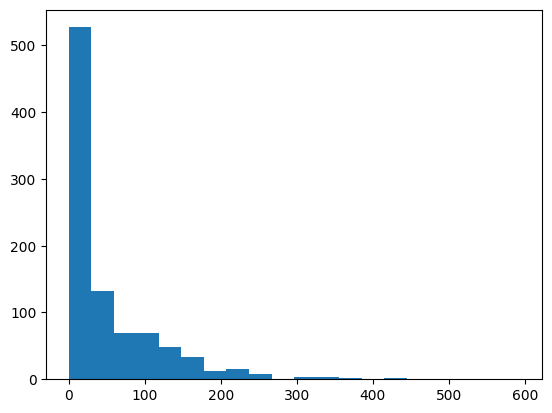

In [40]:
# plt.hist(df_durations[df_durations['all']>5]['all'], bins=30)
plt.hist(df_durations['all'], bins=20)

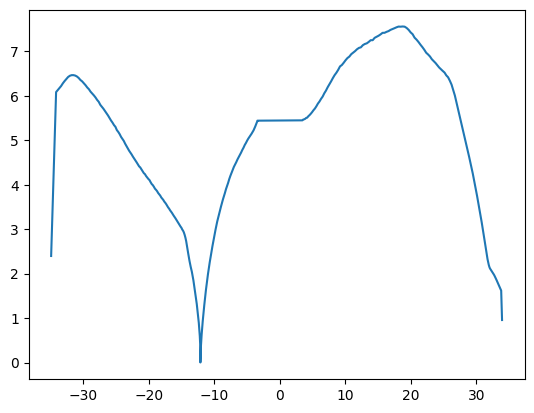

In [21]:
plt.plot(area['Adjusted_1_Head_Center_Distance'], area['Filtered_1_Head_Velocity_Total'])
plt.show()
# px.scatter(area, x='Adjusted_1_Head_Center_Distance', y='Filtered_1_Head_Velocity_Total')
# px.scatter(area, x='1_Head_Center_Distance', y='Filtered_1_Head_Velocity_Total')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


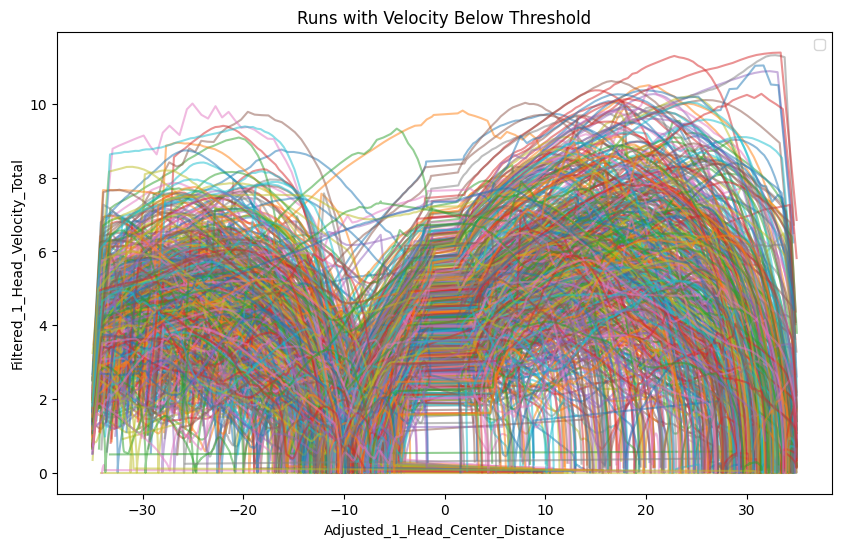

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


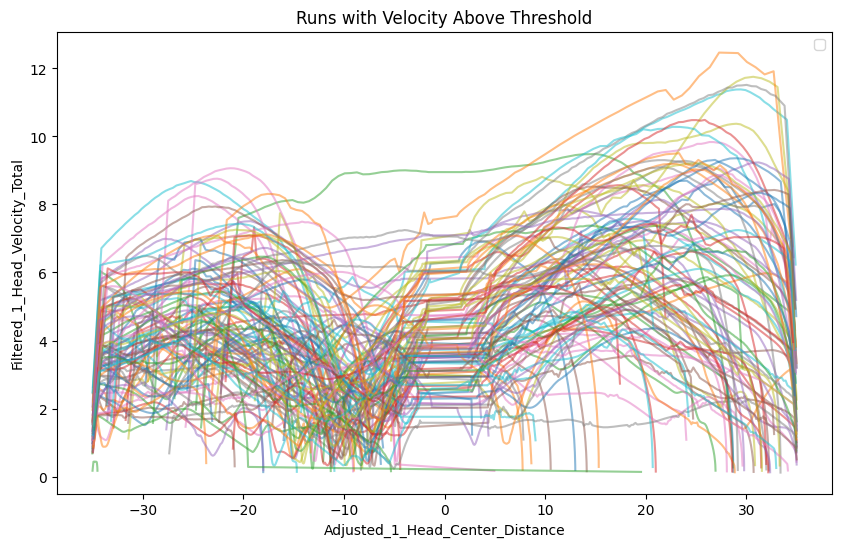

In [22]:
# Define velocity threshold
velocity_threshold = 0.1

# Initialize lists to hold runs below and above the threshold
stopped_runs = {}
nonstopped_runs = {}
min_velocity = []

# Categorize the runs based on the threshold
for run, df in data_by_run.items():
    min_velocity.append(df['Filtered_1_Head_Velocity_Total'].min())
    if df['Filtered_1_Head_Velocity_Total'].min() < velocity_threshold:
        stopped_runs[run] = df
    else:
        nonstopped_runs[run] = df

# Plot runs below the threshold
plt.figure(figsize=(10, 6))
plt.xlabel('Adjusted_1_Head_Center_Distance')
plt.ylabel('Filtered_1_Head_Velocity_Total')
plt.title('Runs with Velocity Below Threshold')

for run, df in stopped_runs.items():
    plt.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total'], alpha=0.5)#, label=f'Run: {run}')
    # plt.plot( df['Filtered_1_Head_Velocity_Total'], alpha=0.5)

plt.legend()
plt.show()

# Plot runs above the threshold
plt.figure(figsize=(10, 6))
plt.xlabel('Adjusted_1_Head_Center_Distance')
plt.ylabel('Filtered_1_Head_Velocity_Total')
plt.title('Runs with Velocity Above Threshold')

for run, df in nonstopped_runs.items():
    plt.plot(df['Adjusted_1_Head_Center_Distance'], df['Filtered_1_Head_Velocity_Total'], alpha=0.5)#, label=f'Run: {run}')
    # plt.plot( df['Filtered_1_Head_Velocity_Total'], alpha=0.5)
    
plt.legend()
plt.show()


In [152]:
len(stopped_runs), len(nonstopped_runs)

(858, 130)

In [153]:
fig = px.box(min_velocity)
fig.show()

In [154]:
fig = px.histogram([x for x in min_velocity if x < 0.0049])
fig.show()

# How long did the car stop?

In [50]:
# Define velocity threshold
velocity_threshold = 0.05

# Initialize lists to hold runs below and above the threshold
stopped_runs = {}
not_stopped_runs = {}
min_velocity = []
stopped_durations = {}
all_stopped_durations = []

# Categorize the runs based on the threshold and calculate stopped durations
for run, df in data_by_run.items():
    min_velocity.append(df['Filtered_1_Head_Velocity_Total'].min())
    
    if df['Filtered_1_Head_Velocity_Total'].min() < velocity_threshold:
        stopped_runs[run] = df
        stopped_durations[run] = {}
        
        # Calculate how long the car was stopped
        velocity_below_threshold = df['Filtered_1_Head_Velocity_Total'] < velocity_threshold
        total_stopped_time = 0
        current_stopped_time = 0
        stopped_period = 0
        
        for i in range(len(velocity_below_threshold)):
            if velocity_below_threshold.iloc[i]:
                current_stopped_time += 1  # Increment the count for continuous stop
            else:
                if current_stopped_time > 0:
                    stopped_period += 1
                    stopped_durations[run][stopped_period] = current_stopped_time
                    all_stopped_durations.append(current_stopped_time)
                    total_stopped_time += current_stopped_time
                    current_stopped_time = 0
        
        # Add the final continuous stopped time if the last period was a stop
        if current_stopped_time > 0:
            stopped_durations[run]['end'] = current_stopped_time
            total_stopped_time += current_stopped_time
        
        # Store the total stopped duration
        # stopped_durations[run]['all'] = total_stopped_time
        stopped_durations[run]['all-end'] = total_stopped_time - current_stopped_time
        
    else:
        not_stopped_runs[run] = df

# Output the stopped durations
for run, duration in stopped_durations.items():
    print(f"Run: {run}, Stopped Duration: {duration}")

Run: CP7_NYC_22_1B, Stopped Duration: {1: 12, 'end': 39, 'all-end': 12}
Run: CP3_NYC_22_1A, Stopped Duration: {'end': 32, 'all-end': 0}
Run: CP2_NYC_22_1A, Stopped Duration: {1: 33, 'all-end': 33}
Run: CP2_NYC_22_1B, Stopped Duration: {1: 22, 2: 22, 3: 87, 'end': 23, 'all-end': 131}
Run: CP6_NYC_1_1A, Stopped Duration: {1: 14, 'end': 9, 'all-end': 14}
Run: CP6_NYC_1_1B, Stopped Duration: {1: 15, 'all-end': 15}
Run: CP7_NYC_1_1A, Stopped Duration: {'end': 13, 'all-end': 0}
Run: CP7_NYC_25_1B, Stopped Duration: {'end': 15, 'all-end': 0}
Run: CP3_NYC_25_1B, Stopped Duration: {1: 27, 'all-end': 27}
Run: CP1_NYC_25_1A, Stopped Duration: {1: 22, 'all-end': 22}
Run: CP6_NYC_25_1A, Stopped Duration: {1: 23, 'end': 1, 'all-end': 23}
Run: CP6_NYC_25_1B, Stopped Duration: {'end': 96, 'all-end': 0}
Run: CP2_NYC_25_1A, Stopped Duration: {'end': 36, 'all-end': 0}
Run: CP5_NYC_25_1B, Stopped Duration: {'end': 45, 'all-end': 0}
Run: CP7_NYC_13_1A, Stopped Duration: {'end': 127, 'all-end': 0}
Run: CP7_

In [156]:
len(stopped_runs), len(not_stopped_runs)

(798, 130)

In [157]:
pd.DataFrame(data=all_stopped_durations).describe()

,0
count,869.000000
mean,61.988493
std,62.753889
min,1.000000
25%,21.000000
50%,40.000000
75%,83.000000
max,603.000000


In [159]:
fig = px.box(all_stopped_durations)
fig.show()

In [160]:
# fig = px.histogram([x for x in all_stopped_durations if x > 3 and x < 100], nbins=50)
fig = px.histogram(all_stopped_durations, nbins=100)
fig.show()


- plot the jerk

# Calculate Initial Status


In [ ]:
# Loop through each scenario
for scenario, areas in data_by_scenario.items():
    # Create a new figure for each scenario
    plt.figure(figsize=(10, 6))
    plt.title(f'Scenario: {scenario}')
    plt.xlabel('1_Head_Center_Distance')
    plt.ylabel('Filtered_1_Head_Velocity_Total')
    
    # Plot each run in the scenario
    for innerArea in areas:
        # Filter the DataFrame for the first continuous decreasing series within the specified distance range
        df_filtered = innerArea[(innerArea['1_Head_Center_Distance'] <= 35) & 
                                (innerArea['1_Head_Center_Distance'] > 0)]
        
        # Find the first continuous decreasing sequence
        continuous_decreasing_indices = []
        
        if df_filtered.shape[0] > 0:
            previous_index = df_filtered.index[0]

            for idx in df_filtered.index:
                if (idx == previous_index + 1) and (df_filtered.loc[idx, '1_Head_Center_Distance'] < df_filtered.loc[previous_index, '1_Head_Center_Distance']):
                    continuous_decreasing_indices.append(idx)
                else:
                    if idx > previous_index + 1:
                        break  # Stop if a new series is detected
                previous_index = idx

            if continuous_decreasing_indices:
                continuous_decreasing_indices.insert(0, df_filtered.index[0])

            df_series = df_filtered.loc[continuous_decreasing_indices]
            
            plt.plot(df_series['1_Head_Center_Distance'], df_series['Filtered_1_Head_Velocity_Total'])

    plt.legend()
    plt.show()


# Testing inputs for car A

# centerline things


In [ ]:
# Functions for centerline

# Function to resample a path to a fixed number of points
def resample_path(df, car='A', num_points=400):
    col_x = 'HeadPosX' + car
    col_y = 'HeadPosZ' + car
    if col_x not in df.columns or col_y not in df.columns:
        raise KeyError(f"Columns '{col_x}' and '{col_y}' are required in the DataFrame")
    
    # Calculate the cumulative distance along the path
    distances = np.sqrt(np.diff(df[col_x])**2 + np.diff(df[col_y])**2)
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    
    # Interpolation functions for X and Y coordinates
    interp_func_x = interp1d(cumulative_distances, df[col_x], kind='linear')
    interp_func_y = interp1d(cumulative_distances, df[col_y], kind='linear')
    
    # New distance values for resampling
    new_distances = np.linspace(0, cumulative_distances[-1], num=num_points)
    
    # Interpolated X and Y coordinates
    resampled_x = interp_func_x(new_distances)
    resampled_y = interp_func_y(new_distances)
    
    return pd.DataFrame({col_x: resampled_x, col_y: resampled_y})
    
# Function to compute the median start and end points
def compute_median_start_end(paths, col_x, col_y):
    start_points = pd.DataFrame({col_x: [path[col_x].iloc[0] for path in paths], 
                                 col_y: [path[col_y].iloc[0] for path in paths]})
    end_points = pd.DataFrame({col_x: [path[col_x].iloc[-1] for path in paths], 
                               col_y: [path[col_y].iloc[-1] for path in paths]})
    median_start = start_points.median()
    median_end = end_points.median()
    return median_start, median_end    

# Function to detect outliers based on start and end points
def detect_outliers_by_start_end(paths, median_start, median_end, col_x, col_y, threshold):
    cleaned_paths = []
    for path in paths:
        start_distance = np.sqrt((path[col_x].iloc[0] - median_start[col_x])**2 + (path[col_y].iloc[0] - median_start[col_y])**2)
        end_distance = np.sqrt((path[col_x].iloc[-1] - median_end[col_x])**2 + (path[col_y].iloc[-1] - median_end[col_y])**2)
        if start_distance <= threshold and end_distance <= threshold:
            cleaned_paths.append(path)
    return cleaned_paths

## By Scenarios and Locations

In [ ]:
# Resample paths for each scenario and location
resampled_data_by_scenario_location_A = {}
resampled_data_by_scenario_location_B = {}

for scenario, locations in data_by_scenario_location.items():
    resampled_data_by_scenario_location_A[scenario] = {}
    resampled_data_by_scenario_location_B[scenario] = {}
    for location, runs in locations.items():
        resampled_runs_A = [resample_path(run, car='A') for run in runs]
        resampled_runs_B = [resample_path(run, car='B') for run in runs]
        resampled_data_by_scenario_location_A[scenario][location] = resampled_runs_A
        resampled_data_by_scenario_location_B[scenario][location] = resampled_runs_B

# Remove outliers for each scenario and location
cleaned_data_by_scenario_location_A = {}
cleaned_data_by_scenario_location_B = {}

threshold = 10

for scenario, locations in resampled_data_by_scenario_location_A.items():
    cleaned_data_by_scenario_location_A[scenario] = {}
    cleaned_data_by_scenario_location_B[scenario] = {}
    for location, resampled_runs_A in locations.items():
        resampled_runs_B = resampled_data_by_scenario_location_B[scenario][location]
        median_start_A, median_end_A = compute_median_start_end(resampled_runs_A, 'HeadPosXA', 'HeadPosZA')
        median_start_B, median_end_B = compute_median_start_end(resampled_runs_B, 'HeadPosXB', 'HeadPosZB')
        cleaned_paths_A = detect_outliers_by_start_end(resampled_runs_A, median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
        cleaned_paths_B = detect_outliers_by_start_end(resampled_runs_B, median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
        cleaned_data_by_scenario_location_A[scenario][location] = cleaned_paths_A
        cleaned_data_by_scenario_location_B[scenario][location] = cleaned_paths_B

# Compute the centerline for each scenario and location after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, locations in cleaned_data_by_scenario_location_A.items():
    centerlines_A[scenario] = {}
    centerlines_B[scenario] = {}
    for location, cleaned_runs_A in locations.items():
        combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
        average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
        centerlines_A[scenario][location] = average_path_A

for scenario, locations in cleaned_data_by_scenario_location_B.items():
    for location, cleaned_runs_B in locations.items():
        combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
        average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
        centerlines_B[scenario][location] = average_path_B

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario and location
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # # Plot individual runs for car A
    # for location, runs in cleaned_data_by_scenario_location_A[scenario].items():
    #     for run in runs:
            # plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # # Plot individual runs for car B
    # for location, runs in cleaned_data_by_scenario_location_B[scenario].items():
    #     for run in runs:
    #         plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A by location
    for location, centerline in centerlines_A[scenario].items():
        plt.plot(centerline['HeadPosXA'], centerline['HeadPosZA'], linewidth=2, label=f'Centerline A - {location}')
    
    # Plot the centerline for car B by location
    for location, centerline in centerlines_B[scenario].items():
        plt.plot(centerline['HeadPosXB'], centerline['HeadPosZB'], linewidth=2, label=f'Centerline B - {location}')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()


## By Scenarios only

In [ ]:
# Resample paths for each scenario
resampled_data_by_scenario_A = {}
resampled_data_by_scenario_B = {}

for scenario, runs in data_by_scenario.items():
    resampled_runs_A = [resample_path(run,car='A') for run in runs]
    resampled_runs_B = [resample_path(run,car='B') for run in runs]
    resampled_data_by_scenario_A[scenario] = resampled_runs_A
    resampled_data_by_scenario_B[scenario] = resampled_runs_B

# Display the resampled data structure
print(resampled_data_by_scenario_A.keys())

# Remove outliers for each scenario
cleaned_data_by_scenario_A = {}
cleaned_data_by_scenario_B = {}

threshold = 10

for scenario in resampled_data_by_scenario_A.keys():
    median_start_A, median_end_A = compute_median_start_end(resampled_data_by_scenario_A[scenario], 'HeadPosXA', 'HeadPosZA')
    median_start_B, median_end_B = compute_median_start_end(resampled_data_by_scenario_B[scenario], 'HeadPosXB', 'HeadPosZB')
    cleaned_paths_A = detect_outliers_by_start_end(resampled_data_by_scenario_A[scenario], median_start_A, median_end_A, 'HeadPosXA', 'HeadPosZA', threshold)
    cleaned_paths_B = detect_outliers_by_start_end(resampled_data_by_scenario_B[scenario], median_start_B, median_end_B, 'HeadPosXB', 'HeadPosZB', threshold)
    cleaned_data_by_scenario_A[scenario] = cleaned_paths_A
    cleaned_data_by_scenario_B[scenario] = cleaned_paths_B
    
# Compute the centerline for each scenario and each car after removing outliers
centerlines_A = {}
centerlines_B = {}

for scenario, cleaned_runs_A in cleaned_data_by_scenario_A.items():
    combined_resampled_A = pd.concat(cleaned_runs_A, keys=range(len(cleaned_runs_A)), names=['Run_ID', 'Point_ID'])
    average_path_A = combined_resampled_A.groupby('Point_ID').median().reset_index()
    centerlines_A[scenario] = average_path_A

for scenario, cleaned_runs_B in cleaned_data_by_scenario_B.items():
    combined_resampled_B = pd.concat(cleaned_runs_B, keys=range(len(cleaned_runs_B)), names=['Run_ID', 'Point_ID'])
    average_path_B = combined_resampled_B.groupby('Point_ID').median().reset_index()
    centerlines_B[scenario] = average_path_B

In [ ]:
def save_centerlines(centerlines, scenario, car_type):
    # Create the full path for the file
    file_path = os.path.join(FilteredDataPathCenterlines, f'centerline_{scenario}_{car_type}.feather')
    
    # Save the DataFrame to a Feather file
    centerlines.to_feather(file_path)
    print(f"Saved centerline for {scenario} ({car_type}) to {file_path}")

# Save centerlines for car A
for scenario, centerline_df in centerlines_A.items():
    save_centerlines(centerline_df, scenario, 'A')

# Save centerlines for car B
for scenario, centerline_df in centerlines_B.items():
    save_centerlines(centerline_df, scenario, 'B')

In [ ]:
# Define the maximum distance for the circle
MaxDistance = 31

# Plot the centerline and individual paths for each scenario
for scenario in centerlines_A.keys():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot individual runs for car A
    counter_A = 0
    for run in cleaned_data_by_scenario_A[scenario]:
        counter_A += 1
        plt.plot(run['HeadPosXA'], run['HeadPosZA'], alpha=0.3)#, label='Individual Run A')

    # Plot individual runs for car B
    counter_B = 0
    for run in cleaned_data_by_scenario_B[scenario]:
        counter_B += 1
        plt.plot(run['HeadPosXB'], run['HeadPosZB'], alpha=0.3)#, label='Individual Run B')
    
    # Plot the centerline for car A
    plt.plot(centerlines_A[scenario]['HeadPosXA'], centerlines_A[scenario]['HeadPosZA'], color='red', linewidth=2, label='Centerline A')
    
    # Plot the centerline for car B
    plt.plot(centerlines_B[scenario]['HeadPosXB'], centerlines_B[scenario]['HeadPosZB'], color='blue', linewidth=2, label='Centerline B')
    
    # Set limits and add the circle
    ax.set_xlim(-31, 31)
    ax.set_ylim(-31, 31)
    ax.set_aspect('equal', adjustable='box')
    circle = Circle((0, 0), MaxDistance, color='blue', fill=False)  # Center at (0,0)
    ax.add_patch(circle)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Centerline and Individual Runs for Scenario {scenario}')
    plt.legend()
    plt.show()
    print(f"{scenario}: {counter_A} Runs for A, {counter_B} Runs for B")

In [ ]:
centerlines_A['CP1']